<a href="https://colab.research.google.com/github/sushgho/Msc-Project/blob/master/LDA_for_amazon_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install PyDrive
!pip install gensim
!pip install pyldavis
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:

import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import spacy

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:

df = pd.read_csv('amazon_reviews.txt', sep="\t")
df.shape

(21000, 9)

In [5]:
df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will save the day. Just keep it around just in case you need it for something."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement 3200mAh Li-Ion Battery for Samsung Galaxy Note 3 [24-Month Warranty] with NFC Chip + Google Wallet Capable,New era for batteries,Lithium batteries are something new introduced in the market there average developing cost is relatively high but Stallion doesn't compromise on quality and provides us with the best at a low cost...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 months now and has pretty much out grown it. It is very loud and doesn't swing very well. It is beautiful though. I love the colors and it has a lot of...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolatur and here it is. It works and does everything I need. Only issue is that it tilts slightly to one side so when I hit any keys it rocks a little bit....
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitening System - No Sensitivity,Only use twice a week,"I only use it twice a week and the results are great. I have used other teeth whitening solutions and most of them, for the same results I would have to use it at least three times a week. Will ke..."


In [6]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

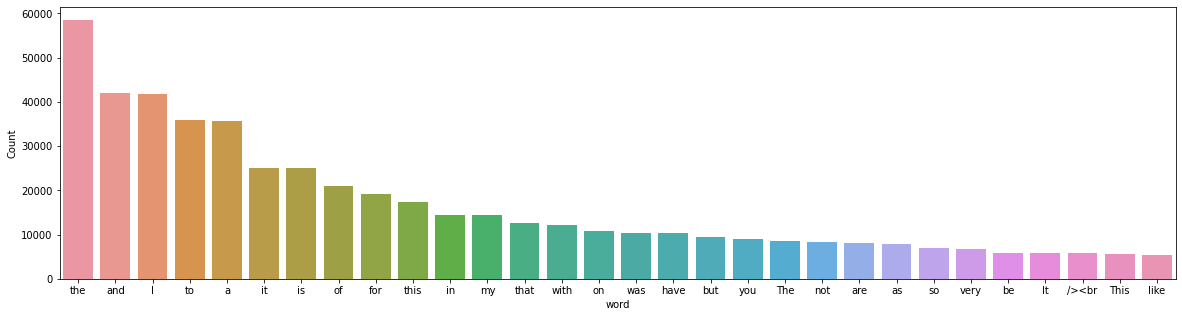

In [7]:
freq_words(df['REVIEW_TEXT'])

In [8]:
# replace "n't" with " not"
df['REVIEW_TEXT'] = df['REVIEW_TEXT'].str.replace("n\'t", " not")

# remove unwanted characters, numbers and symbols
df['REVIEW_TEXT'] = df['REVIEW_TEXT'].str.replace("[^a-zA-Z#]", " ")


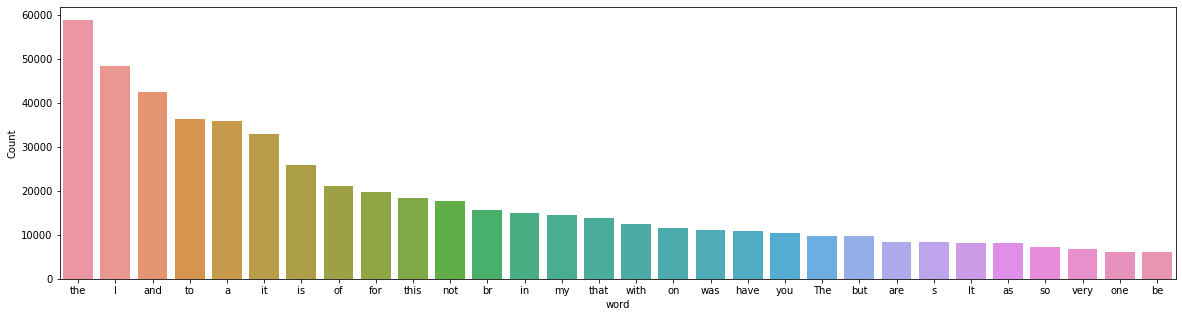

In [9]:
freq_words(df['REVIEW_TEXT'])

In [10]:

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [11]:

# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [28]:

# remove short words (length < 3)
df['REVIEW_TEXT'] = df['REVIEW_TEXT'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['REVIEW_TEXT']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

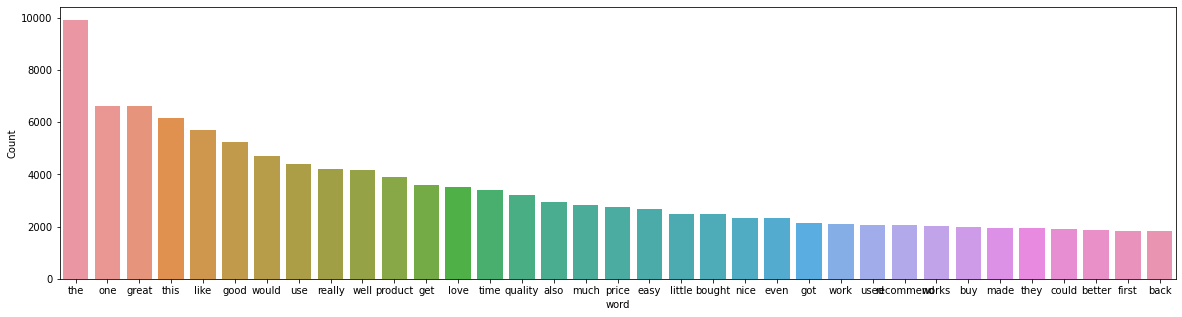

In [13]:

freq_words(reviews, 35)

In [14]:

nlp = spacy.load('en', disable=['parser', 'ner'])

In [15]:

def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [16]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['lithium', 'batteries', 'something', 'new', 'introduced', 'market', 'average', 'developing', 'cost', 'relatively', 'high', 'stallion', 'compromise', 'quality', 'provides', 'best', 'low', 'cost', 'there', 'many', 'built', 'technical', 'assistants', 'act', 'like', 'sensor', 'particular', 'fort', 'the', 'battery', 'keeps', 'phone', 'charged', 'works', 'every', 'voltage', 'high', 'voltage', 'never', 'risked']


In [17]:
print(tokenized_reviews[1])
len(tokenized_reviews[1])

['lithium', 'batteries', 'something', 'new', 'introduced', 'market', 'average', 'developing', 'cost', 'relatively', 'high', 'stallion', 'compromise', 'quality', 'provides', 'best', 'low', 'cost', 'there', 'many', 'built', 'technical', 'assistants', 'act', 'like', 'sensor', 'particular', 'fort', 'the', 'battery', 'keeps', 'phone', 'charged', 'works', 'every', 'voltage', 'high', 'voltage', 'never', 'risked']


40

In [18]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

['lithium', 'battery', 'new', 'market', 'average', 'cost', 'high', 'stallion', 'compromise', 'quality', 'low', 'cost', 'many', 'technical', 'assistant', 'act', 'sensor', 'particular', 'battery', 'phone', 'high', 'voltage']


In [19]:
len(reviews_2[1])

22

In [20]:
set(tokenized_reviews[1]) - set(reviews_2[1])

{'assistants',
 'batteries',
 'best',
 'built',
 'charged',
 'developing',
 'every',
 'fort',
 'introduced',
 'keeps',
 'like',
 'never',
 'provides',
 'relatively',
 'risked',
 'something',
 'the',
 'there',
 'works'}

In [21]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

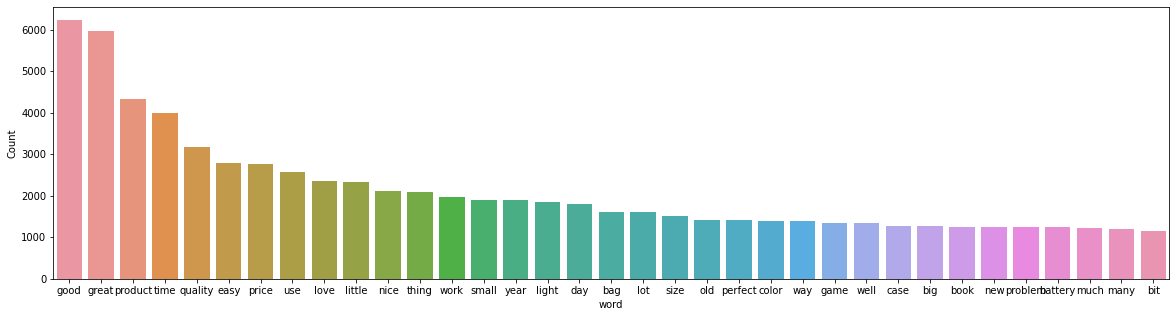

In [22]:
freq_words(df['reviews'], 35)

In [23]:

# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

In [24]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [25]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [26]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

Streaming output truncated to the last 5000 lines.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Us

In [27]:
lda_model.print_topics()

[(0,
  '0.026*"book" + 0.017*"movie" + 0.012*"time" + 0.012*"good" + 0.010*"story" + 0.009*"great" + 0.008*"many" + 0.008*"life" + 0.007*"character" + 0.007*"year"'),
 (1,
  '0.018*"water" + 0.009*"dog" + 0.007*"filter" + 0.007*"entire" + 0.007*"bike" + 0.006*"printer" + 0.006*"break" + 0.006*"business" + 0.006*"duty" + 0.006*"switch"'),
 (2,
  '0.034*"good" + 0.032*"great" + 0.026*"product" + 0.023*"price" + 0.023*"quality" + 0.016*"size" + 0.013*"love" + 0.011*"color" + 0.011*"nice" + 0.010*"perfect"'),
 (3,
  '0.030*"game" + 0.029*"product" + 0.018*"year" + 0.013*"day" + 0.013*"car" + 0.012*"old" + 0.012*"time" + 0.011*"new" + 0.010*"great" + 0.009*"week"'),
 (4,
  '0.021*"watch" + 0.019*"time" + 0.012*"little" + 0.012*"old" + 0.010*"plastic" + 0.009*"year" + 0.009*"easy" + 0.009*"love" + 0.009*"hair" + 0.009*"daughter"'),
 (5,
  '0.027*"light" + 0.024*"bag" + 0.018*"easy" + 0.014*"use" + 0.013*"small" + 0.010*"thing" + 0.009*"large" + 0.008*"pocket" + 0.008*"little" + 0.008*"enough

In [69]:
from pprint import pprint
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]


[(0,
  '0.026*"book" + 0.017*"movie" + 0.012*"time" + 0.012*"good" + 0.010*"story" '
  '+ 0.009*"great" + 0.008*"many" + 0.008*"life" + 0.007*"character" + '
  '0.007*"year"'),
 (1,
  '0.018*"water" + 0.009*"dog" + 0.007*"filter" + 0.007*"entire" + '
  '0.007*"bike" + 0.006*"printer" + 0.006*"break" + 0.006*"business" + '
  '0.006*"duty" + 0.006*"switch"'),
 (2,
  '0.034*"good" + 0.032*"great" + 0.026*"product" + 0.023*"price" + '
  '0.023*"quality" + 0.016*"size" + 0.013*"love" + 0.011*"color" + '
  '0.011*"nice" + 0.010*"perfect"'),
 (3,
  '0.030*"game" + 0.029*"product" + 0.018*"year" + 0.013*"day" + 0.013*"car" + '
  '0.012*"old" + 0.012*"time" + 0.011*"new" + 0.010*"great" + 0.009*"week"'),
 (4,
  '0.021*"watch" + 0.019*"time" + 0.012*"little" + 0.012*"old" + '
  '0.010*"plastic" + 0.009*"year" + 0.009*"easy" + 0.009*"love" + 0.009*"hair" '
  '+ 0.009*"daughter"'),
 (5,
  '0.027*"light" + 0.024*"bag" + 0.018*"easy" + 0.014*"use" + 0.013*"small" + '
  '0.010*"thing" + 0.009*"large"

In [42]:
# Compute Perplexity
from gensim.models import CoherenceModel
print('\n Perplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Coherence Score: ', coherence_lda)

Streaming output truncated to the last 5000 lines.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Us


Perplexity:  -7.768044431403552

Coherence Score:  0.451960022528096


Perplexity:  **-7.768044431403552**

coherence score of **0.45**.

In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model,doc_term_matrix , dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.138202 -0.000718       1        1  22.475042
6      0.081960  0.045110       2        1  16.035490
5      0.088790 -0.221940       3        1  15.842093
3      0.028388  0.153495       4        1  12.875181
4      0.097402 -0.120511       5        1  12.863563
0     -0.033429  0.221547       6        1  12.470662
1     -0.401314 -0.076984       7        1   7.437971, topic_info=         Term         Freq        Total Category  logprob  loglift
3     product  3691.000000  3691.000000  Default  30.0000  30.0000
66       game  1501.000000  1501.000000  Default  29.0000  29.0000
346     light  1625.000000  1625.000000  Default  28.0000  28.0000
331       bag  1478.000000  1478.000000  Default  27.0000  27.0000
19    quality  2676.000000  2676.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1462   useful   138.964935   244.125275   Topic7  -5.3329   2.0351
80        oil   150.856873   341.640717   Topic7  -5.2508   1.7811
234    bottle   155.324615   396.768921   Topic7  -5.2216   1.6607
296     clean   150.847626   545.728638   Topic7  -5.2508   1.3127
550     paper   111.533752   259.935364   Topic7  -5.5528   1.7525

[417 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1344      3  0.994936      access
2245      6  0.991759      action
1789      1  0.994592      adjust
1372      5  0.997323  adjustable
2654      1  0.996473  adjustment
...     ...       ...         ...
75        4  0.451641        year
75        5  0.231497        year
75        6  0.160419        year
552       4  0.137091       young
552       6  0.858090       young

[631 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 4, 5, 1, 2])

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
# Create Document — Topic Matrix
lda_output = lda_model.transform(data_vectorized)

AttributeError: ignored

In [65]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

NameError: ignored

In [51]:

def create_topics_table(model, vectorizer, n_words):
    keywords = np.array(vectorizer.dictionary())
    topics = []
    for weights in model.components_:
        top_index = (-weights).argsort()[:n_words]
        #topic = keywords.take(top_index)
        #w = np.sort(-weights)[:5]
        #w = w.round(1)
        #w = w.astype(str)
        #ind = map(' '.join, zip(topic, w))
        #topics.append(ind)
        topics.append(keywords.take(top_index))
    return topics

In [53]:
print('Top 10 words for each topic with LDA')
topic_keywords = create_topics_table(model=lda_model, vectorizer=doc_term_matrix, n_words=10)       
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
display(df_topic_keywords)

Top 10 words for each topic with LDA


AttributeError: ignored